In [1]:
import numpy as np
import torch as th
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import pandas as pd

In [2]:
df = pd.read_csv('koi_data.csv')
print(df.columns)

Index(['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad',
       'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor',
       'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count',
       'koi_num_transits', 'koi_tce_plnt_num', 'koi_steff', 'koi_slogg',
       'koi_srad', 'koi_smass', 'ra', 'dec', 'koi_kepmag', 'koi_gmag',
       'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag'],
      dtype='object')


In [3]:
from sklearn.model_selection import train_test_split

# Separate predictors and label
X = df.drop(columns=['koi_disposition'])
y = df['koi_disposition']

# Split into training and testing sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the testing set into validation and testing sets (50% of 20% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 6228
Validation set size: 778
Testing set size: 779


In [4]:
from torch.utils.data import DataLoader, TensorDataset

# Convert pandas DataFrames/Series to PyTorch tensors
X_train_tensor = th.tensor(X_train.values, dtype=th.float32)
y_train_tensor = th.tensor(y_train.values, dtype=th.long)
X_val_tensor = th.tensor(X_val.values, dtype=th.float32)
y_val_tensor = th.tensor(y_val.values, dtype=th.long)
X_test_tensor = th.tensor(X_test.values, dtype=th.float32)
y_test_tensor = th.tensor(y_test.values, dtype=th.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch 1/75
Train Loss: 5417.5604
Validation Loss: 66.8426
Validation Accuracy: 41.00%
Epoch 2/75
Train Loss: 189.4823
Validation Loss: 1.0051
Validation Accuracy: 41.65%
Epoch 3/75
Train Loss: 4.3177
Validation Loss: 0.9957
Validation Accuracy: 45.50%
Epoch 4/75
Train Loss: 2.0834
Validation Loss: 1.0008
Validation Accuracy: 45.50%
Epoch 5/75
Train Loss: 1.5190
Validation Loss: 1.0060
Validation Accuracy: 45.50%
Epoch 6/75
Train Loss: 1.2762
Validation Loss: 1.0092
Validation Accuracy: 45.50%
Epoch 7/75
Train Loss: 1.1038
Validation Loss: 1.0118
Validation Accuracy: 45.50%
Epoch 8/75
Train Loss: 1.2654
Validation Loss: 1.0158
Validation Accuracy: 45.50%
Epoch 9/75
Train Loss: 1.5494
Validation Loss: 1.0174
Validation Accuracy: 45.50%
Epoch 10/75
Train Loss: 1.1855
Validation Loss: 1.0169
Validation Accuracy: 45.50%
Epoch 11/75
Train Loss: 1.4258
Validation Loss: 1.0183
Validation Accuracy: 45.50%
Epoch 12/75
Train Loss: 1.0663
Validation Loss: 1.0169
Validation Accuracy: 45.50%
Epoch 1

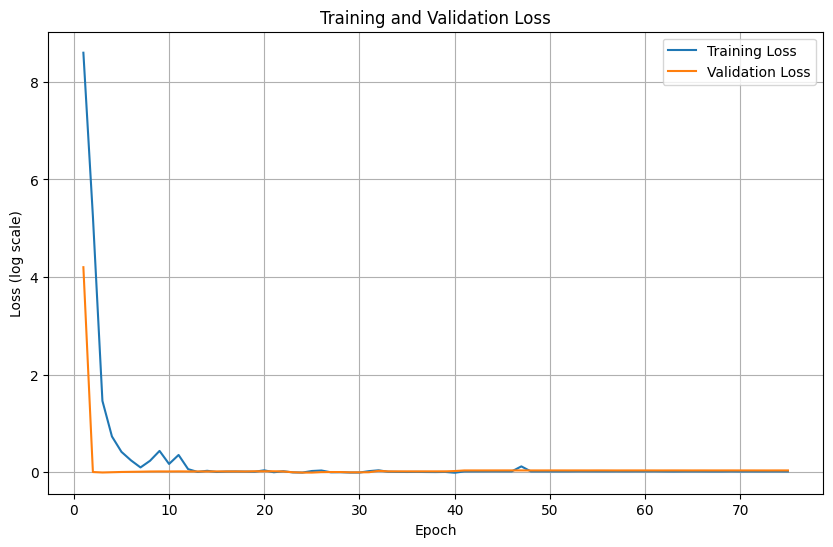

Test Loss: 1.0036
Test Accuracy: 50.32%


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from NeuralNet import FeedForwardNN  # Import the FeedForwardNN class
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define the model
input_size = X_train.shape[1]  # Number of features
hidden_sizes = [32, 64, 128]  # Hidden layer sizes
model = FeedForwardNN(input_size=input_size, hidden_sizes=hidden_sizes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to log losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 75
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    # Log losses
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_losses[-1]:.4f}")
    print(f"Validation Loss: {val_losses[-1]:.4f}")
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), np.log(train_losses), label='Training Loss')
plt.plot(range(1, num_epochs + 1), np.log(val_losses), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Testing phase
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")

### Now with PCA

In [6]:
# Load the new dataframe
new_df = pd.read_csv('new_dataframe.csv')

# Separate predictors and label
X_new = new_df.drop(columns=['koi_disposition'])
y_new = new_df['koi_disposition']

# Split into training and testing sets (80% train, 20% test)
X_new_train, X_new_temp, y_new_train, y_new_temp = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Further split the testing set into validation and testing sets (50% of 20% each)
X_new_val, X_new_test, y_new_val, y_new_test = train_test_split(X_new_temp, y_new_temp, test_size=0.5, random_state=42)

# Convert pandas DataFrames/Series to PyTorch tensors
X_new_train_tensor = th.tensor(X_new_train.values, dtype=th.float32)
y_new_train_tensor = th.tensor(y_new_train.values, dtype=th.long)
X_new_val_tensor = th.tensor(X_new_val.values, dtype=th.float32)
y_new_val_tensor = th.tensor(y_new_val.values, dtype=th.long)
X_new_test_tensor = th.tensor(X_new_test.values, dtype=th.float32)
y_new_test_tensor = th.tensor(y_new_test.values, dtype=th.long)

# Create TensorDatasets
new_train_dataset = TensorDataset(X_new_train_tensor, y_new_train_tensor)
new_val_dataset = TensorDataset(X_new_val_tensor, y_new_val_tensor)
new_test_dataset = TensorDataset(X_new_test_tensor, y_new_test_tensor)

# Create DataLoaders
new_train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)
new_val_loader = DataLoader(new_val_dataset, batch_size=32, shuffle=False)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

# Define the model
new_input_size = X_new_train.shape[1]  # Number of features
PCA_model = FeedForwardNN(input_size=new_input_size, hidden_sizes=hidden_sizes)

# Define the loss function and optimizer
new_criterion = nn.CrossEntropyLoss()
new_optimizer = optim.Adam(PCA_model.parameters(), lr=0.001, weight_decay = 1e-5)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(new_optimizer, step_size=50, gamma=0.1)

# Initialize lists to log losses
new_train_losses = []
new_val_losses = []

# New number of epochs
num_epochs = 300

# Training loop
for epoch in range(num_epochs):
    # Training phase
    PCA_model.train()
    new_train_loss = 0
    for batch_X, batch_y in new_train_loader:
        new_optimizer.zero_grad()
        outputs = PCA_model(batch_X)
        loss = new_criterion(outputs, batch_y)
        loss.backward()
        new_optimizer.step()
        new_train_loss += loss.item()

    # Validation phase
    PCA_model.eval()
    new_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in new_val_loader:
            outputs = PCA_model(batch_X)
            loss = new_criterion(outputs, batch_y)
            new_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    # Log losses
    new_train_losses.append(new_train_loss / len(new_train_loader))
    new_val_losses.append(new_val_loss / len(new_val_loader))

    scheduler.step()  # Step the scheduler

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {new_train_losses[-1]:.4f}")
    print(f"Validation Loss: {new_val_losses[-1]:.4f}")
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Testing phase
PCA_model.eval()
new_test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in new_test_loader:
        outputs = PCA_model(batch_X)
        loss = new_criterion(outputs, batch_y)
        new_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print()
print(f"Test Loss: {new_test_loss / len(new_test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch 1/300
Train Loss: 0.8042
Validation Loss: 0.5725
Validation Accuracy: 74.42%
Epoch 2/300
Train Loss: 0.5982
Validation Loss: 0.5363
Validation Accuracy: 76.22%
Epoch 3/300
Train Loss: 0.5627
Validation Loss: 0.5187
Validation Accuracy: 76.22%
Epoch 4/300
Train Loss: 0.5388
Validation Loss: 0.5148
Validation Accuracy: 76.86%
Epoch 5/300
Train Loss: 0.5300
Validation Loss: 0.5030
Validation Accuracy: 77.51%
Epoch 6/300
Train Loss: 0.5221
Validation Loss: 0.5005
Validation Accuracy: 77.12%
Epoch 7/300
Train Loss: 0.5090
Validation Loss: 0.4924
Validation Accuracy: 77.25%
Epoch 8/300
Train Loss: 0.5052
Validation Loss: 0.4866
Validation Accuracy: 77.63%
Epoch 9/300
Train Loss: 0.5001
Validation Loss: 0.4839
Validation Accuracy: 77.51%
Epoch 10/300
Train Loss: 0.4915
Validation Loss: 0.4844
Validation Accuracy: 78.28%
Epoch 11/300
Train Loss: 0.4922
Validation Loss: 0.4790
Validation Accuracy: 78.02%
Epoch 12/300
Train Loss: 0.4933
Validation Loss: 0.4761
Validation Accuracy: 78.02%
E

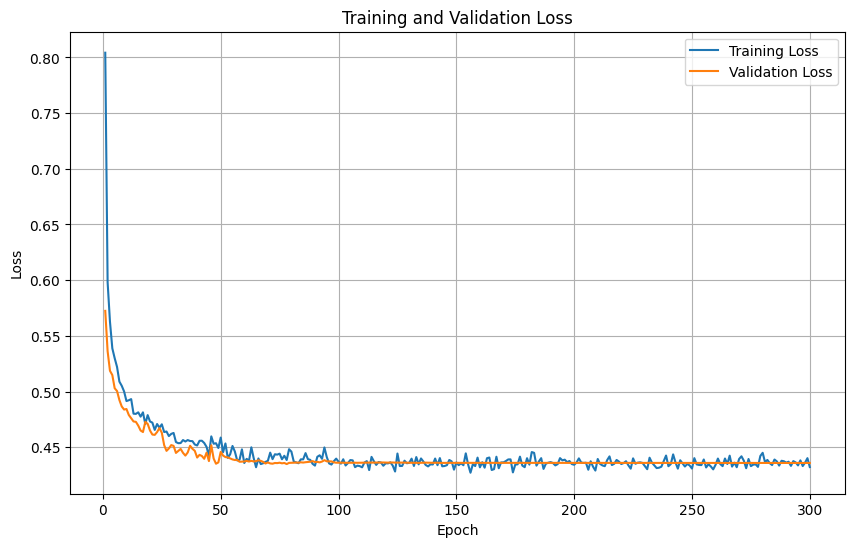

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), new_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), new_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [8]:
from sklearn.metrics import classification_report

# Function to evaluate a model
def evaluate_model(model, data_loader, y_true_tensor):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch_X, _ in data_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
    y_true = y_true_tensor.cpu().numpy()
    return classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])

# Evaluate PCA_model
print("Evaluation for PCA_model:")
print(evaluate_model(PCA_model, new_test_loader, y_new_test_tensor))

# Evaluate model
print("\nEvaluation for model:")
print(evaluate_model(model, test_loader, y_test_tensor))

Evaluation for PCA_model:
              precision    recall  f1-score   support

     Class 0       0.92      0.93      0.93       392
     Class 1       0.52      0.25      0.33       142
     Class 2       0.69      0.89      0.78       245

    accuracy                           0.79       779
   macro avg       0.71      0.69      0.68       779
weighted avg       0.78      0.79      0.77       779


Evaluation for model:
              precision    recall  f1-score   support

     Class 0       0.50      1.00      0.67       392
     Class 1       0.00      0.00      0.00       142
     Class 2       0.00      0.00      0.00       245

    accuracy                           0.50       779
   macro avg       0.17      0.33      0.22       779
weighted avg       0.25      0.50      0.34       779



/Users/kevinhan/opt/anaconda3/envs/babyRL/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevinhan/opt/anaconda3/envs/babyRL/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevinhan/opt/anaconda3/envs/babyRL/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier